In [119]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pickle
import json

from shapely import wkt

from joblib import Parallel, delayed
import multiprocessing

import scipy.stats as stats
from scipy.spatial import distance
from sklearn.preprocessing import OrdinalEncoder
from easydict import EasyDict as edict
from tqdm import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

import powerlaw



In [120]:
# import sys
# sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils.utils import setup_seed, load_config

In [121]:
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [122]:
def _apply_parallel(ls, func, n=-1, **kwargs):
    """parallel apply for spending up."""
    length = len(ls)
    cpunum = multiprocessing.cpu_count()
    if length < cpunum:
        spnum = length
    if n < 0:
        spnum = cpunum + n + 1
    else:
        spnum = n or 1

    return Parallel(n_jobs=n, verbose=0)(delayed(func)(seq, **kwargs) for seq in ls)

# Read 

## Read sequences

In [123]:
# file_name = ".\\runs\mobis_diffseq_evaluate_v2_b\seed101_solverstep10.json"
file_name = ".\\data\\validation\\seed101_solverstep20_ema21_small.json"

In [124]:
def read_seq(file_name):

    predict_ls = []
    true_ls = []
    src_ls = []
    with open(file_name, "r") as f_reader:
        for row in f_reader:
            content = json.loads(row)

            src_ls.append((np.array(content["source"])[:-1]))

            reference_arr = np.array(content["reference"])
            try:
                reference_arr = reference_arr[:np.where(reference_arr == 0)[0][0]]
            except IndexError:
                reference_arr = reference_arr
            true_ls.append(reference_arr)

            if len(content["recover"]) >= 50:
                predict_ls.append(np.array(content["recover"][:50]).squeeze())
            else:
                print(len(content["recover"]))
    return predict_ls, true_ls, src_ls

predict_ls, true_ls, src_ls = read_seq(file_name)

## Read all locations

In [125]:
# initialization
config = load_config("./config/diff.yml")
config = edict(config)

In [126]:
all_locs = pd.read_csv(os.path.join("data", "s2_loc_visited_level10_13.csv"), index_col="id")
all_locs["geometry"] = all_locs["geometry"].apply(wkt.loads)
all_locs = gpd.GeoDataFrame(all_locs, geometry="geometry", crs="EPSG:4326")
# transform to projected coordinate systems
all_locs = all_locs.to_crs("EPSG:2056")

In [127]:
enc = OrdinalEncoder(dtype=np.int64, handle_unknown="use_encoded_value", unknown_value=-1).fit(
    all_locs["loc_id"].values.reshape(-1, 1)
)
all_locs["loc_id"] = enc.transform(all_locs["loc_id"].values.reshape(-1, 1)) + 2

In [128]:
all_locs

,loc_id,level,geometry,freq,area
id,,,,,
0,2,10,POINT (2824875.045 1159436.528),1,POLYGON ((10.405097146225662 46.50637570678295...
1,3,13,POINT (2822437.857 1167754.527),38,POLYGON ((10.347820052132302 46.61871685680636...
2,4,13,POINT (2815796.126 1167304.569),1,POLYGON ((10.260953592346382 46.61685460820135...
3,5,13,POINT (2816020.303 1168362.492),1,POLYGON ((10.264376293749178 46.62629143145975...
4,6,13,POINT (2818994.419 1169160.037),1,POLYGON ((10.303565033130825 46.63249007077394...
...,...,...,...,...,...
14876,14878,13,POINT (2767507.842 1213073.682),1,"POLYGON ((9.64763962539829 47.042237657717536,..."
14877,14879,13,POINT (2768419.907 1212986.551),1,"POLYGON ((9.65960383635977 47.04122268391671, ..."
14878,14880,13,POINT (2769332.126 1212899.406),1,"POLYGON ((9.671569607102107 47.04020629289218,..."


## Read Markov generation

In [73]:
file_name = ".\\data\\validation\\mobis_markov_generation_small.json"

markov_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)


        markov_ls.append(np.array(content["recover"]).squeeze())


## Read MHSA generation

In [176]:
file_name = ".\\data\\validation\\mobis_mhsa_generation_small2.json"

ar_ls = []
with open(file_name, "r") as f_reader:
    for row in f_reader:
        content = json.loads(row)


        ar_ls.append(np.array(content["recover"]).squeeze())


# Jump length

In [177]:
def get_jumplength(seq, geo_x, geo_y):
    locs = seq - 2 # padding and seperator

    return np.array([np.sqrt((geo_x[locs][i] - geo_x[locs][i - 1])**2 + (geo_y[locs][i] - geo_y[locs][i - 1])**2) for i in range(1, len(locs))])

In [178]:
geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

predict_jp = np.hstack(_apply_parallel(predict_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
true_jp = np.hstack(_apply_parallel(true_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
source_jp = np.hstack(_apply_parallel(src_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))

predict_jp = predict_jp[predict_jp>1]
true_jp = true_jp[true_jp>1]
source_jp = source_jp[source_jp>1]

In [179]:
markov_jp = np.hstack(_apply_parallel(markov_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))
ar_jp = np.hstack(_apply_parallel(ar_ls, get_jumplength, n=-1, geo_x=geo_x, geo_y=geo_y))


ar_jp = ar_jp[ar_jp>1]
markov_jp = markov_jp[markov_jp>1]

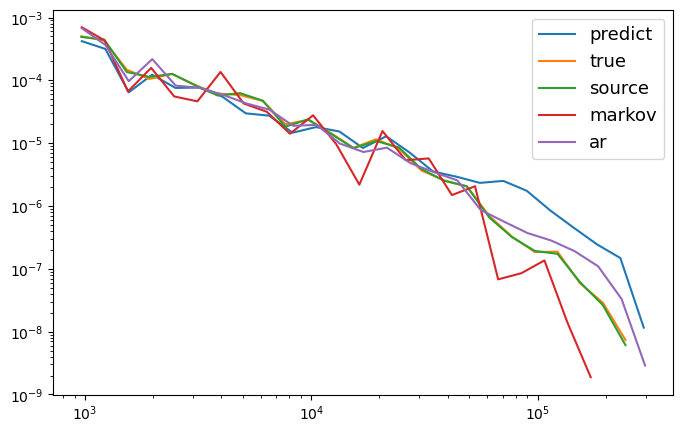

In [180]:
plt.figure(figsize=(8, 5))


# fit power law
fit = powerlaw.Fit(true_jp, xmin=1)

# plotting
powerlaw.plot_pdf(predict_jp, label="predict")
powerlaw.plot_pdf(true_jp, label="true")
powerlaw.plot_pdf(source_jp, label="source")
powerlaw.plot_pdf(markov_jp, label="markov")
powerlaw.plot_pdf(ar_jp, label="ar")

# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 13})
plt.show()

In [181]:
# predict = np.log(predict_jp)
# true = np.log(true_jp)
# source = np.log(source_jp)

predict = predict_jp
true = true_jp
source = source_jp

In [182]:
min = predict.min()
max = predict.max()
pred_dist_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_dist_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_dist_p, _ =  np.histogram(source, bins=1000, range=(min, max))

pred_true_js = distance.jensenshannon(pred_dist_p, true_dist_p)
source_true_js = distance.jensenshannon(source_dist_p, true_dist_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.258	 Source and True: 0.048


In [183]:
markov_dist_p, _ =  np.histogram(markov_jp, bins=1000, range=(min, max))
markov_true_js = distance.jensenshannon(markov_dist_p, true_dist_p)

ar_dist_p, _ =  np.histogram(ar_jp, bins=1000, range=(min, max))
ar_true_js = distance.jensenshannon(ar_dist_p, true_dist_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}")

Markov and True: 0.262	 AR and True: 0.141


# Visit frequency

In [184]:
def get_loc_p(ls):
    visits = np.zeros(shape=(len(all_locs)), dtype=float)
    for seq in ls:
        locs = seq - 2 # padding and seperator

        visits[locs] += 1
    visits.sort()
    visits = visits[::-1]
    return visits

In [185]:
predict_p = get_loc_p(predict_ls)
true_p = get_loc_p(true_ls)
source_p = get_loc_p(src_ls)

markov_p = get_loc_p(markov_ls)
ar_p = get_loc_p(ar_ls)

In [186]:
predict_p, true_p, source_p, markov_p, ar_p

(array([7748., 4426., 4227., ...,    0.,    0.,    0.]),
 array([4654., 3428., 2270., ...,    0.,    0.,    0.]),
 array([6521., 4924., 2784., ...,    0.,    0.,    0.]),
 array([1685., 1508., 1432., ...,    0.,    0.,    0.]),
 array([5005., 3721., 2200., ...,    0.,    0.,    0.]))

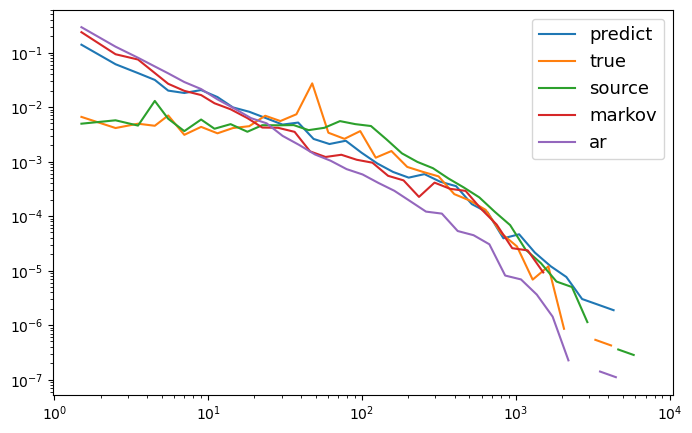

In [187]:
plt.figure(figsize=(8, 5))

predict = predict_p[predict_p>0]
true = true_p[true_p>0]
source = source_p[source_p>0]

markov = markov_p[markov_p>0]
ar = ar_p[ar_p>0]
# plotting
powerlaw.plot_pdf(predict, label="predict")
powerlaw.plot_pdf(true, label="true")
powerlaw.plot_pdf(source, label="source")
powerlaw.plot_pdf(markov, label="markov")
powerlaw.plot_pdf(ar, label="ar")

plt.legend(prop={"size": 13})
plt.show()

In [188]:
# predict = np.log(predict_p[:100])
# true = np.log(true_p[:100])
# source = np.log(source_p[:100])

predict = predict_p
true = true_p
source = source_p

In [189]:
pred_true_js = distance.jensenshannon(predict, true)
source_true_js = distance.jensenshannon(source, true)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.377	 Source and True: 0.061


In [190]:
markov_true_js = distance.jensenshannon(markov_p, true)
ar_true_js = distance.jensenshannon(ar_p, true)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}")

Markov and True: 0.365	 AR and True: 0.166


# Rg

In [191]:
def get_rg(ls, geo_x, geo_y):
    rgs = []

    for seq in ls:
        locs = seq - 2 # padding and seperator

        xs = np.take(geo_x, locs)
        ys = np.take(geo_y, locs)

        x_center = np.average(xs)
        y_center = np.average(ys)

        square_rg = np.average((xs - x_center) ** 2 + (ys - y_center) ** 2)

        rgs.append(np.sqrt(square_rg))
    return np.array(rgs, dtype=float)

In [192]:
geo_x = all_locs["geometry"].x.values
geo_y = all_locs["geometry"].y.values

predict_rg = get_rg(predict_ls, geo_x, geo_y)
true_rg = get_rg(true_ls, geo_x, geo_y)
source_rg = get_rg(src_ls, geo_x, geo_y)

predict_rg = predict_rg[predict_rg>1]
true_rg = true_rg[true_rg>1]
source_rg = source_rg[source_rg>1]

In [193]:
markov_rg = get_rg(markov_ls, geo_x, geo_y)
markov_rg = markov_rg[markov_rg>1]

ar_rg = get_rg(ar_ls, geo_x, geo_y)
ar_rg = ar_rg[ar_rg>1]

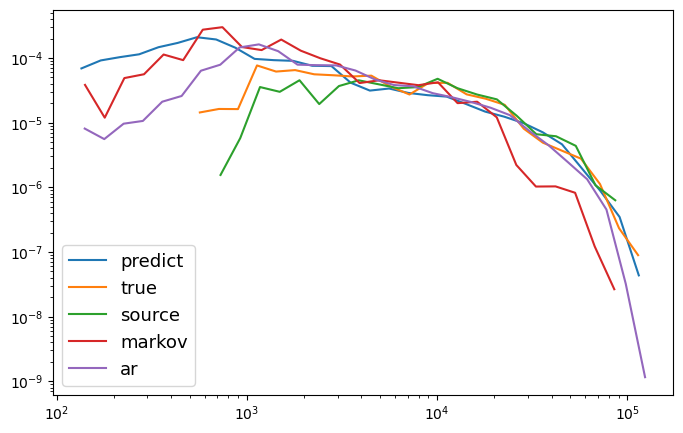

In [194]:
plt.figure(figsize=(8, 5))

# fit power law
fit = powerlaw.Fit(true_rg, xmin=1)

# plotting
powerlaw.plot_pdf(predict_rg, label="predict")
powerlaw.plot_pdf(true_rg, label="true")
powerlaw.plot_pdf(source_rg, label="source")

powerlaw.plot_pdf(markov_rg, label="markov")
powerlaw.plot_pdf(ar_rg, label="ar")

# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 13})
plt.show()

In [195]:
# predict = np.log(predict_rg)
# true = np.log(true_rg)
# source = np.log(source_rg)

predict = predict_rg
true = true_rg
source = source_rg

In [196]:
min = predict.min()
max = predict.max()
pred_rg_p, _ = np.histogram(predict, bins=1000, range=(min, max))
true_rg_p, _ =  np.histogram(true, bins=1000, range=(min, max))
source_rg_p, _ =  np.histogram(source, bins=1000, range=(min, max))

pred_true_js = distance.jensenshannon(pred_rg_p, true_rg_p)
source_true_js = distance.jensenshannon(source_rg_p, true_rg_p)

print(f"Prediction and True: {pred_true_js:.3f}\t Source and True: {source_true_js:.3f}")

Prediction and True: 0.268	 Source and True: 0.185


In [197]:
markov_rg_p, _ =  np.histogram(markov_rg, bins=1000, range=(min, max))
markov_true_js = distance.jensenshannon(markov_rg_p, true_rg_p)

ar_rg_p, _ =  np.histogram(ar_rg, bins=1000, range=(min, max))
ar_true_js = distance.jensenshannon(ar_rg_p, true_rg_p)

print(f"Markov and True: {markov_true_js:.3f}\t AR and True: {ar_true_js:.3f}")

Markov and True: 0.349	 AR and True: 0.204


# Language metrics

In [198]:
def bleu_score(recover, reference):
    return sentence_bleu(
        [reference],
        recover,
        smoothing_function=SmoothingFunction().method4,
    )

def get_scores(pred_ls, ref_ls):
    bleu_ls = []
    for pred, ref in zip(pred_ls, ref_ls):

        bleu_ls.append(bleu_score(pred, ref))
    return bleu_ls

def get_self_bleu(ls):
    selfBleu = []
    for i, seq in tqdm(enumerate(ls)):
        for j in range(i + 1, len(ls)):
            score = bleu_score(seq, ls[j])
            selfBleu.append(score)
    return np.mean(selfBleu)

def distinct_n_gram_inter_sent(hypn, n):
    hyp_ngrams = []
    for hyp in hypn:
        hyp_ngrams += nltk.ngrams(hyp, n)
    total_ngrams = len(hyp_ngrams)
    unique_ngrams = len(list(set(hyp_ngrams)))

    dist_n = unique_ngrams / total_ngrams
    return dist_n

def distinct_n_gram(hypn, n=1):
    dist_list = []
    for hyp in hypn:
        n1_grams = list(nltk.ngrams(hyp, n))
        dist_list.append(len(set(n1_grams))/len(n1_grams))
    return np.mean(dist_list)

## BLEU

In [199]:
predict_src_bleu = get_scores(predict_ls, src_ls)
true_src_bleu = get_scores(true_ls, src_ls)
predict_true_bleu = get_scores(predict_ls, true_ls)

print(f"Prediction and True: {np.average(predict_true_bleu):.3f}\nSource and True: {np.average(true_src_bleu):.3f}\nPrediction and Source: {np.average(predict_src_bleu):.3f}")

Prediction and True: 0.077
Source and True: 0.181
Prediction and Source: 0.059


In [200]:
markov_true_bleu = get_scores(markov_ls, true_ls)
ar_true_bleu = get_scores(ar_ls, true_ls)

print(f"Markov and True: {np.average(markov_true_bleu):.3f}\nAR and True: {np.average(ar_true_bleu):.3f}")

Markov and True: 0.303
AR and True: 0.277


## Self-bleu
Lower self-bleu suggests higher diversity

In [98]:
# slow
predict_bleu = get_self_bleu(predict_ls)
true_bleu = get_self_bleu(true_ls)
src_bleu = get_self_bleu(src_ls)

1it [00:05,  5.78s/it]


KeyboardInterrupt: 

## Diverse 4-gram
Higher div-4 suggests higher diversity

In [201]:
pred_div4 = distinct_n_gram_inter_sent(predict_ls, 4)
true_div4 = distinct_n_gram_inter_sent(true_ls, 4)
src_div4 = distinct_n_gram_inter_sent(src_ls, 4)

print(f"Prediction: {pred_div4:.4f}\nSource: {src_div4:.4f}\nTrue: {true_div4:.4f}")

Prediction: 0.2011
Source: 0.0086
True: 0.0162


In [202]:
markov_div4 = distinct_n_gram_inter_sent(markov_ls, 4)
ar_div4 = distinct_n_gram_inter_sent(ar_ls, 4)

print(f"Markov: {markov_div4:.4f}\nAR: {ar_div4:.4f}")

Markov: 0.0120
AR: 0.2612


## Distinct unigrams (1-gram)
intra-diversity within each sequence. Lower dist means more repeated tokens.

In [203]:
predict_1_gram = distinct_n_gram(predict_ls)
true_1_gram = distinct_n_gram(true_ls)
src_1_gram = distinct_n_gram(src_ls)

print(f"Prediction: {predict_1_gram:.4f}\nSource: {src_1_gram:.4f}\nTrue: {true_1_gram:.4f}")

Prediction: 0.1087
Source: 0.1892
True: 0.2418


In [204]:
markov_1_gram = distinct_n_gram(markov_ls)
ar_1_gram = distinct_n_gram(ar_ls)

print(f"Markov: {markov_1_gram:.4f}\nAR: {ar_1_gram:.4f}")

Markov: 0.0770
AR: 0.1999


# Entropy

In [205]:
def real_entropy_individual(locs_series):

    n = len(locs_series)

    # 1 to ensure to consider the first situation from where
    # locs_series[i:j] = [] and locs_series[i:j] = locs_series[0:1]
    sum_lambda = 1

    for i in range(1, n - 1):
        j = i + 1

        while True:
            # if the locs_series[i:j] is longer than locs_series[:i],
            # we can no longer find it locs_series[i:j] in locs_series[:i]
            if j - i > i:
                break

            # if locs_series[i:j] exist in locs_series[:i], we increase j by 1
            # sliding_window_view creates sublist of length len(locs_series[i:j]) from locs_series[:i]
            ls = np.lib.stride_tricks.sliding_window_view(locs_series[:i], j - i).tolist()
            if tuple(locs_series[i:j]) in list(map(tuple, ls)):
                # if the subsequence already exist, we increase the sequence by 1, and check again
                j += 1
            else:
                # we find the "shortest substring" that does not exist in locs_series[:i]
                break

        # length of the substring
        sum_lambda += j - i

    # the function S5 from the suppl. material
    return 1.0 / (sum_lambda * 1 / n) * np.log(n)

def uncorrelated_entropy_individual(locs_series):
    _, counts = np.unique(locs_series, return_counts=True)
    freq = counts/len(locs_series)
    return -(freq * np.log(freq)).sum()

## Real entropy

In [206]:
predict_re = _apply_parallel(predict_ls, real_entropy_individual, n=-1)
true_re = _apply_parallel(true_ls, real_entropy_individual, n=-1)
source_re = _apply_parallel(src_ls, real_entropy_individual, n=-1)

In [207]:
markov_re = _apply_parallel(markov_ls, real_entropy_individual, n=-1)
ar_re = _apply_parallel(ar_ls, real_entropy_individual, n=-1)

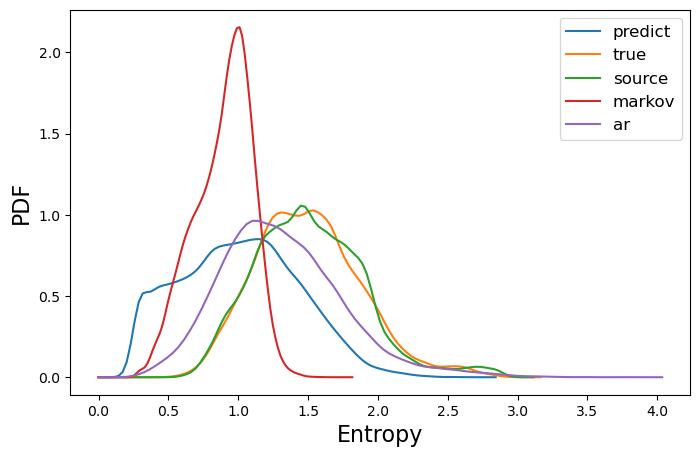

In [208]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

density = stats.gaussian_kde(predict_re)
x = np.linspace(0, np.max(predict_re) + 0.2, 100)
ax.plot(x, density(x), label="predict")

density = stats.gaussian_kde(true_re)
x = np.linspace(0, np.max(true_re) + 0.2, 100)
ax.plot(x, density(x), label="true")

density = stats.gaussian_kde(source_re)
x = np.linspace(0, np.max(source_re) + 0.2, 100)
ax.plot(x, density(x), label="source")

density = stats.gaussian_kde(markov_re)
x = np.linspace(0, np.max(markov_re) + 0.2, 100)
ax.plot(x, density(x), label="markov")

density = stats.gaussian_kde(ar_re)
x = np.linspace(0, np.max(ar_re) + 0.2, 100)
ax.plot(x, density(x), label="ar")

plt.legend(prop={"size": 12})
plt.xlabel("Entropy", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.show()


In [209]:
predict_density = stats.gaussian_kde(predict_re)
true_density = stats.gaussian_kde(true_re)
source_density = stats.gaussian_kde(source_re)

x = np.linspace(0, 3, 1000)

pred_true_re = distance.jensenshannon(predict_density(x), true_density(x))
source_true_re = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_re:.3f}\t Source and True: {source_true_re:.3f}")

Prediction and True: 0.414	 Source and True: 0.047


In [210]:
markov_density = stats.gaussian_kde(markov_re)
ar_density = stats.gaussian_kde(ar_re)

markov_true_re = distance.jensenshannon(markov_density(x), true_density(x))
ar_true_re = distance.jensenshannon(ar_density(x), true_density(x))

print(f"Markov and True: {markov_true_re:.3f}\t AR and True: {ar_true_re:.3f}")

Markov and True: 0.624	 AR and True: 0.206


## Uncorrelated entropy

In [211]:
predict_ue = [uncorrelated_entropy_individual(seq) for seq in predict_ls]
true_ue = [uncorrelated_entropy_individual(seq) for seq in true_ls]
source_ue = [uncorrelated_entropy_individual(seq) for seq in src_ls]

In [212]:
markov_ue = [uncorrelated_entropy_individual(seq) for seq in markov_ls]
ar_ue = [uncorrelated_entropy_individual(seq) for seq in ar_ls]

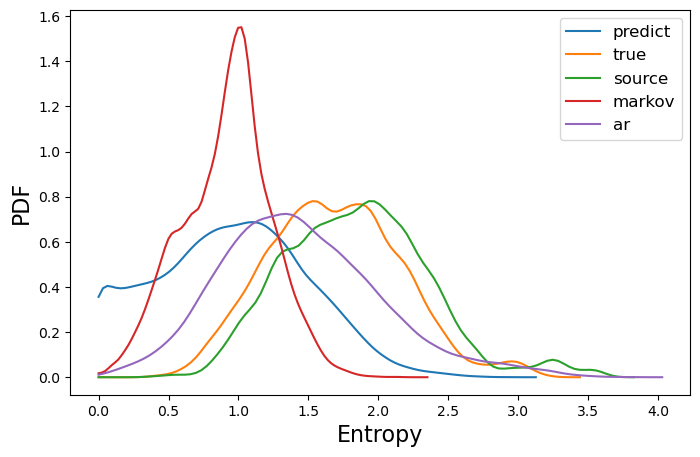

In [213]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))


density = stats.gaussian_kde(predict_ue)
x = np.linspace(0, np.max(predict_ue) + 0.2, 100)
ax.plot(x, density(x), label="predict")

density = stats.gaussian_kde(true_ue)
x = np.linspace(0, np.max(true_ue) + 0.2, 100)
ax.plot(x, density(x), label="true")

density = stats.gaussian_kde(source_ue)
x = np.linspace(0, np.max(source_ue) + 0.2, 100)
ax.plot(x, density(x), label="source")

density = stats.gaussian_kde(markov_ue)
x = np.linspace(0, np.max(markov_ue) + 0.2, 100)
ax.plot(x, density(x), label="markov")

density = stats.gaussian_kde(ar_ue)
x = np.linspace(0, np.max(ar_ue) + 0.2, 100)
ax.plot(x, density(x), label="ar")


plt.legend(prop={"size": 12})
plt.xlabel("Entropy", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.show()


In [214]:
predict_density = stats.gaussian_kde(predict_ue)
true_density = stats.gaussian_kde(true_ue)
source_density = stats.gaussian_kde(source_ue)

x = np.linspace(0, 3, 1000)

pred_true_ue = distance.jensenshannon(predict_density(x), true_density(x))
source_true_ue = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_ue:.3f}\t Source and True: {source_true_ue:.3f}")

Prediction and True: 0.454	 Source and True: 0.109


In [215]:
markov_density = stats.gaussian_kde(markov_ue)
markov_true_ue = distance.jensenshannon(markov_density(x), true_density(x))

ar_density = stats.gaussian_kde(ar_ue)
ar_true_ue = distance.jensenshannon(ar_density(x), true_density(x))

print(f"Markov and True: {markov_true_ue:.3f}\t AR and True: {ar_true_ue:.3f}")

Markov and True: 0.575	 AR and True: 0.209


## Difference between real and uncorrelated

In [216]:
pred_diff = [re - ue for re, ue in zip(predict_re,predict_ue)]
true_diff = [re - ue for re, ue in zip(true_re,true_ue)]
source_diff = [re - ue for re, ue in zip(source_re,source_ue)]

In [217]:
markov_diff = [re - ue for re, ue in zip(markov_re,markov_ue)]
ar_diff = [re - ue for re, ue in zip(ar_re,ar_ue)]

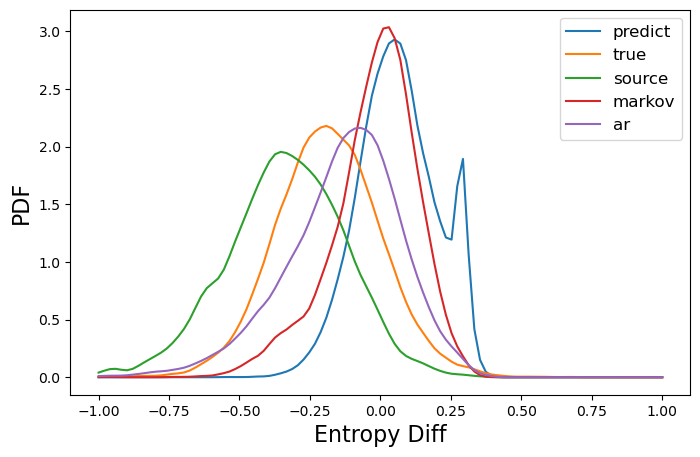

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))


density = stats.gaussian_kde(pred_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="predict")

density = stats.gaussian_kde(true_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="true")

density = stats.gaussian_kde(source_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="source")

density = stats.gaussian_kde(markov_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="markov")

density = stats.gaussian_kde(ar_diff)
x = np.linspace(-1, 1, 100)
ax.plot(x, density(x), label="ar")

plt.legend(prop={"size": 12})
plt.xlabel("Entropy Diff", fontsize=16)
plt.ylabel("PDF", fontsize=16)

plt.show()

In [219]:
predict_density = stats.gaussian_kde(pred_diff)
true_density = stats.gaussian_kde(true_diff)
source_density = stats.gaussian_kde(source_diff)

x = np.linspace(-1, 1, 1000)

pred_true_diff = distance.jensenshannon(predict_density(x), true_density(x))
source_true_diff = distance.jensenshannon(source_density(x), true_density(x))

print(f"Prediction and True: {pred_true_diff:.3f}\t Source and True: {source_true_diff:.3f}")

Prediction and True: 0.488	 Source and True: 0.263


In [220]:
markov_density = stats.gaussian_kde(markov_diff)
markov_true_diff = distance.jensenshannon(markov_density(x), true_density(x))

ar_density = stats.gaussian_kde(ar_diff)
ar_true_diff = distance.jensenshannon(ar_density(x), true_density(x))

print(f"Markov and True: {markov_true_diff:.3f}\t AR and True: {ar_true_diff:.3f}")

Markov and True: 0.340	 AR and True: 0.141
